In [1]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X,dropout):
    assert 0 <= dropout <=1

    #所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    #所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)
    

In [ ]:
X = torch.arange(16,dtype=torch.float32).reshape((2,8))
print(X)
print(dropout_layer(X,0))
print(dropout_layer(X,1))
print(dropout_layer(X,0.5))

In [7]:
num_inputs,num_outputs,num_hiddens1,num_hiddens2 = 784,10,256,256

In [8]:
dropout1,dropout2 = 0.2,0.5

class Net(nn.Module):
    def __init__(self,num_inputs,num_outputs,num_hiddens1,num_hiddens2,is_training = True):
        super(Net,self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs,num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1,num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens1,num_outputs)
        self.relu = nn.ReLU()

    def forward(self,X):
        H1 = self.relu(self.lin1(X.reshape((-1,self.num_inputs))))
        #只有训练模型时才使用dropout
        if self.training == True:
            #在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1,dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            #在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2,dropout2)
        out = self.lin3(H2)
        return out

net = Net(num_inputs,num_outputs,num_hiddens1,num_hiddens2)

In [ ]:
num_epochs,lr,batch_size = 10,0.5,256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(),lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

In [ ]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    nn.ReLU(),
                    #在第一个全连接层之后添加一个dropout层
                    nn.Dropout(dropout1),
                    nn.Linear(256,256),
                    nn.ReLU(),
                    #在第二个全连接层之后添加一个dropout层
                    nn.Dropout(dropout2),
                    nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)

# 将init_weights函数应用到整个神经网络的所有层上
net.apply(init_weights)

In [ ]:
trainer = torch.optim.SGD(net.parameters(),lr = lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)

In [1]:
import torch
from d2l import torch as d2l
from torch import nn
import numpy as np

# 检查MPS是否可用并选择设备
device = torch.device("mps") if torch.backends.mps.is_available() else (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device: {device}")

# 修改Animator定义 用来画多行多列的图
class myAnimator:  
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(4.5, 3.5), wspace=0.5, hspace=0.8):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        
        # 使用lambda函数捕获参数
        self.config_axes = lambda axesnx, axesny: d2l.set_axes(
            self.axes[axesnx, axesny], xlabel, ylabel, xlim, ylim, xscale, yscale, legend
        ) if axesnx == 0 & axesny == 0 else d2l.set_axes(
            self.axes[axesnx, axesny], xlabel, ylabel, xlim, ylim, xscale, yscale, []
        )
        
        d2l.plt.subplots_adjust(wspace=wspace, hspace=hspace)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, axesnx, axesny, x, y, title=None):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[axesnx, axesny].cla()
        if title:
            self.axes[axesnx, axesny].set_title(title)
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[axesnx, axesny].plot(x, y, fmt)
        self.config_axes(axesnx, axesny)
        d2l.display.display(self.fig)
        d2l.display.clear_output(wait=True)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

def Net(dropout1=0.5, dropout2=0.2, num_inputs=784, num_outputs=10, num_hiddens1=256, num_hiddens2=256):
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(num_inputs, num_hiddens1),
        nn.ReLU(),
        nn.Dropout(dropout1),
        nn.Linear(num_hiddens1, num_hiddens2),
        nn.ReLU(),
        nn.Dropout(dropout2),
        nn.Linear(num_hiddens2, num_outputs)
    )
    return net.to(device)  # 将模型移到设备

def changedropout(dropout1list=[0.5], dropout2list=[0.2], num_epochs=10, lr=0.5, batch_size=256,
                  num_inputs=784, num_outputs=10, num_hiddens1=256, num_hiddens2=256, wd=None, figsize=(15, 10),
                  wspace=0.2, hspace=0.3, xlim=[1, 10], ylim=[0.3, 0.9], show=True):
    ndropout1, ndropout2 = len(dropout1list), len(dropout2list)
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    if show == True:
        if (ndropout1 == 1) & (ndropout2 == 1):
            animator = d2l.Animator(xlabel='epoch', ylabel='Y', xlim=xlim, ylim=ylim,
                                    legend=['train loss', 'train acc', 'test acc'], figsize=figsize)
        else:
            animator = myAnimator(xlabel='epoch', ylabel='Y', xlim=[1, num_epochs], ylim=ylim,
                                  legend=['train loss', 'train acc', 'test acc'], nrows=ndropout1, ncols=ndropout2, 
                                  figsize=figsize, wspace=wspace, hspace=hspace)

    train_losslist, train_acclist, test_acclist = np.zeros((ndropout1, ndropout2, num_epochs)), \
                                                  np.zeros((ndropout1, ndropout2, num_epochs)), \
                                                  np.zeros((ndropout1, ndropout2, num_epochs))
    for i in range(ndropout1):
        for j in range(ndropout2):
            dropout1, dropout2 = dropout1list[i], dropout2list[j]
            net = Net(dropout1, dropout2)
            net.apply(init_weights)
            loss = nn.CrossEntropyLoss(reduction='none')
            
            # 将数据移到设备
            train_iter_device = [(X.to(device), y.to(device)) for X, y in train_iter]
            test_iter_device = [(X.to(device), y.to(device)) for X, y in test_iter]
            
            if wd == None:
                trainer = torch.optim.SGD(net.parameters(), lr=lr)
            else:
                paramslist = []
                for m in net:
                    if type(m) == nn.Linear:
                        paramslist.append({"params": m.weight, 'weight_decay': wd})
                        paramslist.append({"params": m.bias})
                trainer = torch.optim.SGD(paramslist, lr=lr)  # 设置权重衰减

            for epoch in range(num_epochs):
                train_metrics = d2l.train_epoch_ch3(net, train_iter_device, loss, trainer)
                test_acc = d2l.evaluate_accuracy(net, test_iter_device)
                train_losslist[i, j, epoch], train_acclist[i, j, epoch], test_acclist[i, j, epoch] = \
                    train_metrics[0], train_metrics[1], test_acc
                
                if show == True:
                    if ndropout1 == 1 & ndropout2 == 1:
                        animator.add(epoch + 1, train_metrics + (test_acc,))
                    else:
                        animator.add(i, j, epoch + 1, train_metrics + (test_acc,), title=f"dropout1:{dropout1},dropout2:{dropout2}")

            if show == True:
                animator.X, animator.Y = None, None

            train_loss, train_acc = train_metrics

    return train_losslist, train_acclist, test_acclist

Using device: mps


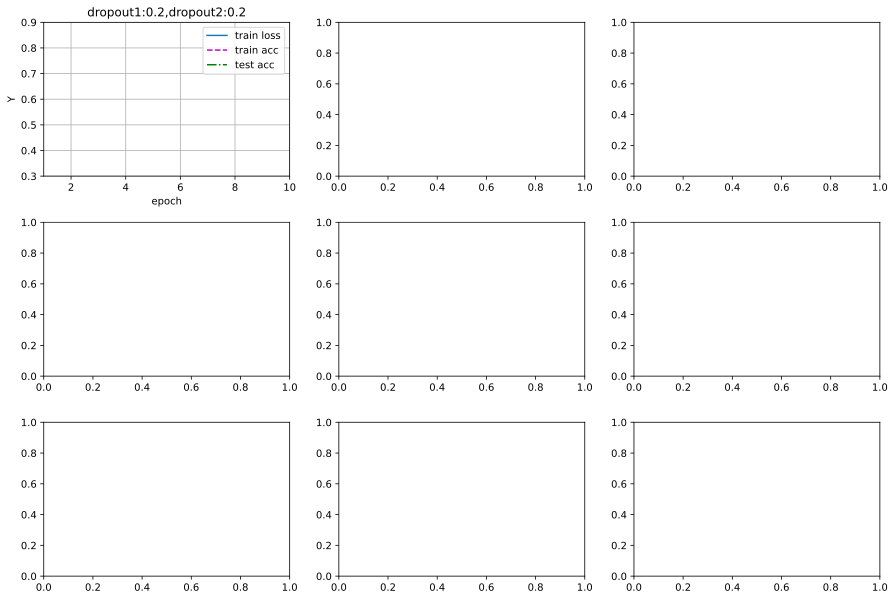

In [2]:
dropout1list,dropout2list=[0.2,0.5,0.7],[0.2,0.5,0.7]
train_losslist,train_acclist,test_acclist=changedropout(dropout1list=[0.2,0.5,0.7],dropout2list=[0.2,0.5,0.7])

In [ ]:
d2l.plt.figure(figsize=(12, 5.5))
d2l.plt.subplot(131)
d2l.plot(list(range(1,11)),np.vstack([train_losslist[i,:,:] for i in range(3)]),'epoch', 'train_loss',
                     legend=[f'dropout1:{dropout1},dropout2:{dropout2}' for dropout1 in dropout1list for dropout2 in dropout1list])
d2l.plt.subplot(132)
d2l.plot(list(range(1,11)),np.vstack([train_acclist[i,:,:] for i in range(3)]),'epoch', 'train_acc')
                     #legend=[f'dropout1:{dropout1},dropout2:{dropout2}' for dropout1 in dropout1list for dropout2 in dropout1list],figsize=(10, 8))
d2l.plt.subplot(133)
d2l.plot(list(range(1,11)),np.vstack([test_acclist[i,:,:] for i in range(3)]),'epoch', 'test_acc')
                     #legend=[f'dropout1:{dropout1},dropout2:{dropout2}' for dropout1 in dropout1list for dropout2 in dropout1list],figsize=(10, 8))
d2l.plt.subplots_adjust(wspace =0.3, hspace =0)
